In [1]:
import nbimporter
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Tuple, Callable
from skopt import gp_minimize
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import r2_score
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from dataloader import load_dataset, get_cryptoquant_data, combineTA_to_OHLCV

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, data_min, data_max, scaler = load_dataset()

In [3]:
print(f"X train shape:{X_train_tensor.shape}")
print(f"X test shape:{X_test_tensor.shape}")
print(f"y train shape:{y_train_tensor.shape}")
print(f"y test shape:{y_test_tensor.shape}")

X train shape:(36753, 20, 8)
X test shape:(15752, 20, 8)
y train shape:(36753, 8)
y test shape:(15752, 8)


In [4]:
# Create a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout_prob: float = 0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        # Attention mechanism
        self.attn_weight = nn.Linear(hidden_size, 1)

        # Output layer: now outputs 8 features
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, input_size),  # output 8 features
        )

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        batch_size = x.shape[0]

        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # LSTM output
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # [batch, seq_len, hidden_size]

        # Attention mechanism
        attn_scores = torch.tanh(self.attn_weight(lstm_out))  # [batch, seq_len, 1]
        attn_weights = F.softmax(attn_scores, dim=1)  # [batch, seq_len, 1]
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden_size]

        # Dropout + final output
        out = self.dropout(context_vector)
        out = self.fc(out)  # [batch, 8]
        return out



In [6]:
torch.manual_seed(42)
# Instantiate a sample model for test
model_LSTM = AttentionLSTM(input_size=8, hidden_size=33, num_layers=3, dropout_prob=0.02)

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr= 0.0003)

In [8]:
def regression_r2(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Compute R² for each feature separately and average
    r2_scores = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(y_true_np.shape[1])]
    return torch.tensor(sum(r2_scores) / len(r2_scores))


In [ ]:
import torch
from typing import Tuple, Callable
import matplotlib.pyplot as plt


def recursive_forecast(
    model: torch.nn.Module,
    initial_input: torch.Tensor,
    forecast_steps: int,
    lookback: int,
    device: torch.device
) -> torch.Tensor:
    
    model.eval()
    forecast = []

    current_input = initial_input.clone().to(device)

    with torch.inference_mode():
        for _ in range(forecast_steps):
            pred = model(current_input)  # [1, output_dim] -> [1, 8]
            forecast.append(pred.squeeze(0))  # [8]

            # Replace last step with predicted features
            new_step = pred.unsqueeze(1)  # [1, 1, 8]
            current_input = torch.cat([current_input[:, 1:], new_step], dim=1)  # slide window

    return torch.stack(forecast)  # [forecast_steps, 8]


def evaluate_forecast(
    forecast: torch.Tensor,
    ground_truth: torch.Tensor,
    loss_fn: torch.nn.Module,
    metrics_fn: Callable[[torch.Tensor, torch.Tensor], float] = None
) -> Tuple[float, float]:
    
    loss_value = loss_fn(forecast, ground_truth).item()
    metrics_value = metrics_fn(forecast, ground_truth).item() if metrics_fn else None
    return loss_value, metrics_value



In [10]:
def run_training_and_testing(
    model: torch.nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    lookback: int,
    device: torch.device,
    epochs: int = 100,
    lr: float = 0.001,
):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Define loss and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Lists to store loss values
    train_loss_history = []
    test_loss_history = []
    
    # Begin training loop
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = loss_fn(y_pred_train, y_train)
        train_loss_history.append(train_loss.item())

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluate every epoch (changed from every 20 epochs)
        with torch.inference_mode():
            # Forecast using recursive strategy
            initial_input = X_test[0].unsqueeze(0)
            forecast_steps = len(y_test)
            y_pred_test = recursive_forecast(model, initial_input, forecast_steps, lookback, device)
            
            test_loss = loss_fn(y_pred_test, y_test[:forecast_steps]).item()
            test_loss_history.append(test_loss)
            
            if epoch % 20 == 0 or epoch == epochs:
                test_r2 = regression_r2(y_pred_test, y_test[:forecast_steps]).item()
                print(f"Epoch [{epoch}/{epochs}]")
                print(f"  Train Loss: {train_loss.item():.5f}")
                print(f"  Test Loss:  {test_loss:.5f} | R² Score: {test_r2:.4f}")

    # Plotting the loss curves
    plt.figure(figsize=(10,5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, y_pred_train, y_pred_test, train_loss_history, test_loss_history

  0%|          | 0/64 [00:00<?, ?it/s]

 31%|███▏      | 20/64 [10:09<21:51, 29.82s/it]

Epoch [20/64]
  Train Loss: 0.03629
  Test Loss:  0.05854 | R² Score: -30148996.0000


 62%|██████▎   | 40/64 [19:07<09:57, 24.89s/it]

Epoch [40/64]
  Train Loss: 0.00667
  Test Loss:  0.02580 | R² Score: -153179968.0000


 94%|█████████▍| 60/64 [28:31<01:46, 26.57s/it]

Epoch [60/64]
  Train Loss: 0.00489
  Test Loss:  0.02379 | R² Score: -137772672.0000


100%|██████████| 64/64 [30:10<00:00, 28.29s/it]

Epoch [64/64]
  Train Loss: 0.00486
  Test Loss:  0.02363 | R² Score: -163073424.0000


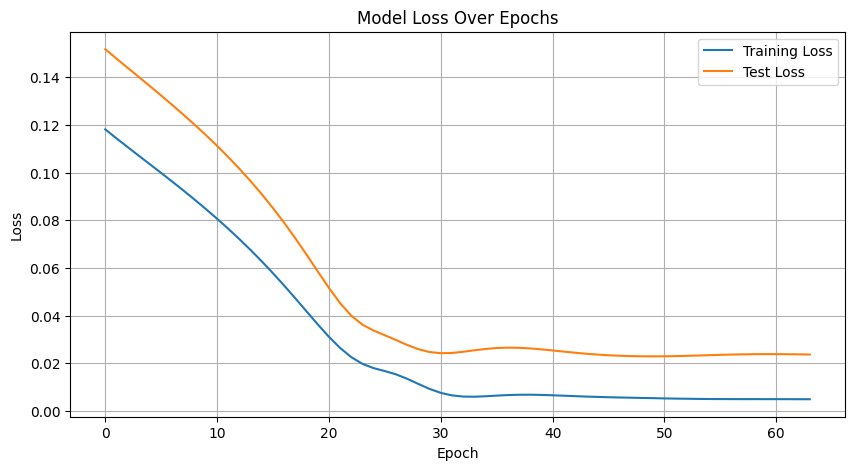

Train time on cpu: 1810.780 seconds


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Measure time
from timeit import default_timer as timer
train_time_start_model_0 = timer()

trained_model, y_pred_train, y_pred_test, train_loss_history, test_loss_history = run_training_and_testing(
    model=model_LSTM,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    lookback=70,
    device=device,
    epochs=64
)

train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                            end=train_time_end_model_0,
                                            device=device)


In [ ]:
def denormalize(data, scaler: MinMaxScaler) -> np.ndarray:
    
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    return scaler.inverse_transform(data)



In [13]:
# Denormalize true and predicted values
y_train_true_denorm = denormalize(y_train_tensor, scaler)
y_train_pred_denorm = denormalize(y_pred_train, scaler)

y_test_true_denorm = denormalize(y_test_tensor, scaler)
y_test_pred_denorm = denormalize(y_pred_test, scaler)


In [ ]:
from skopt import gp_minimize
from skopt.space import Integer, Categorical
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the objective function for Bayesian Optimization
def objective(params):
    # Extract parameters
    num_layers = int(params[0])
    hidden_size = int(params[1])
    lookback = int(params[2])
    num_epochs = int(params[3])
    optimizer_name = params[4]

    X_train_t = torch.FloatTensor(X_train_tensor)
    y_train_t = torch.FloatTensor(y_train_tensor)
    X_test_t = torch.FloatTensor(X_test_tensor)
    y_test_t = torch.FloatTensor(y_test_tensor)
    
    # Model initialization
    model = AttentionLSTM(
        input_size=8,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_prob=0.2  # Fixed dropout
    ).to(device)
    
    # Optimizer selection
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    
    # Training loop (limited epochs for optimization)
    model.train()
    batch_size_bo = 32
    num_epochs = num_epochs
    for epoch in range(num_epochs):  # Reduced epochs for faster optimization
        for i in range(0, len(X_train_t), batch_size_bo):
            inputs = X_train_t[i:i+batch_size_bo].to(device)
            labels = y_train_t[i:i+batch_size_bo].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = recursive_forecast(
            model, 
            X_test_t[0:1],  # Initial sequence
            len(X_test_t),
            lookback,
            device
        )
        val_loss = nn.MSELoss()(test_preds, y_test_t).item()
    
    return val_loss

In [ ]:
# Define search space
param_space = [
    Integer(1, 3, name='num_layers'),          # LSTM layers
    Integer(32, 256, name='hidden_size'),      # Hidden units
    Integer(60, 90, name='lookback'),          # Sequence length
    Integer(100, 400, name='batch_size'),       # Batch size
    Categorical(['adam', 'rmsprop'], name='optimizer')  # Optimizer
]

In [ ]:
# Run optimization
res = gp_minimize(
    objective,
    param_space,
    n_calls=20,       
    random_state=42,
    verbose=True,
    n_jobs=-1           
)

# Best parameters
print(f"Best parameters: {res.x}")
print(f"Best validation MSE: {res.fun}")

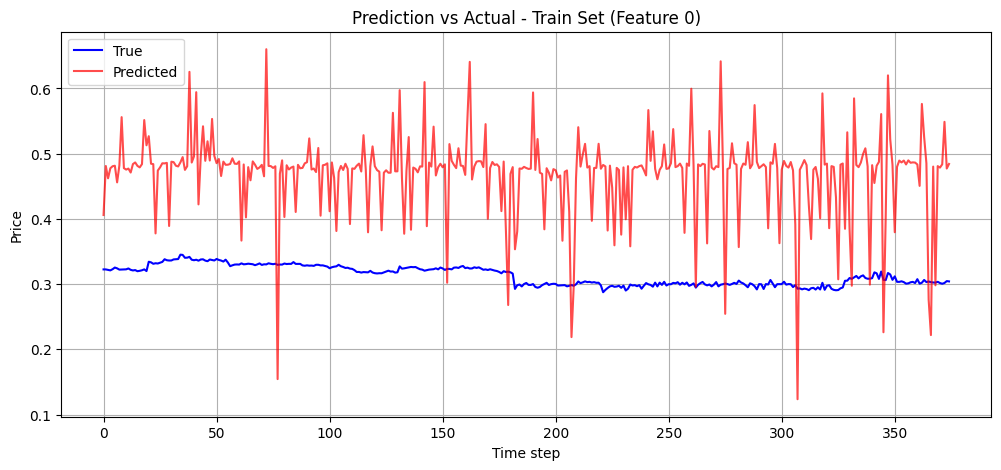

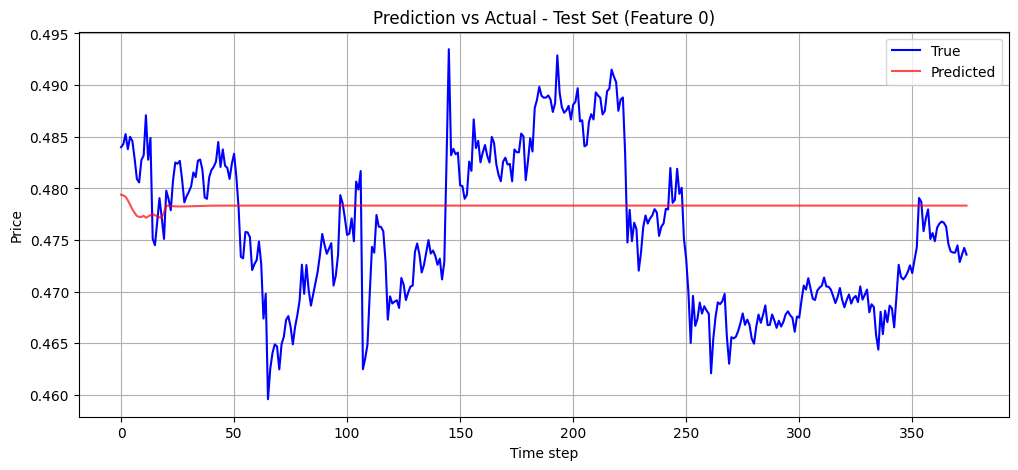

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(true_vals, predicted_vals, title='Prediction vs Actual', feature_idx=0, dataset_type='Train'):
    plt.figure(figsize=(12, 5))
    plt.plot(true_vals[:375, feature_idx], label='True', color='blue')
    plt.plot(predicted_vals[:375, feature_idx], label='Predicted', color='red', alpha=0.7)
    plt.title(f'{title} - {dataset_type} Set (Feature {feature_idx})')
    plt.xlabel('Time step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_train_true_denorm, y_train_pred_denorm, dataset_type='Train', feature_idx=0)
plot_predictions(y_test_true_denorm, y_test_pred_denorm, dataset_type='Test', feature_idx=0)


In [18]:
def create_results_df(y_true_denorm, y_pred_denorm, original_df, lookback=70):
    
    results_df = pd.DataFrame({
        'true_value': y_true_denorm[:, 0],  # First column is 'close' price
        'pred_value': y_pred_denorm[:, 0]   # Predicted 'close' price
    })
    
    # Get corresponding timestamps (skip lookback window)
    test_timestamps = original_df.index[lookback:][-len(y_true_denorm):]
    
    results_df.index = test_timestamps
    results_df.index.name = 'datetime'
    
    return results_df

In [19]:
df = get_cryptoquant_data(filtered=False)
results_df = create_results_df(
    y_test_true_denorm,
    y_test_pred_denorm,
    original_df=df,
    lookback=70
)


In [20]:
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator
from abc import ABC, abstractmethod

In [21]:
prediction_df = results_df[['pred_value']].copy()
prediction_df.rename(columns={'pred_value': 'close'}, inplace=True)
truevalue_df = results_df[['true_value']].copy()
truevalue_df.rename(columns={'true_value': 'close'}, inplace=True)

In [22]:
class ISignalGeneration(ABC):
    @abstractmethod
    def strategic(self, cryptoquant_data):
        pass

In [ ]:
class SignalRegen(ISignalGeneration):
    def strategic(self, data):
        # RSI (14-period) 
        rsi = RSIIndicator(close=data['close'], window=14)
        data['rsi'] = rsi.rsi()

        # MACD (12,26,9) 
        macd = MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
        data['macd'] = macd.macd()
        data['macd_signal'] = macd.macd_signal()
        data['macd_hist'] = macd.macd_diff()

        # Bollinger Bands (20,2) 
        bb = BollingerBands(close=data['close'], window=20, window_dev=2)
        data['bb_upper'] = bb.bollinger_hband()
        data['bb_lower'] = bb.bollinger_lband()
        data['bb_middle'] = bb.bollinger_mavg()

        # Momentum (10-period Rate of Change)
        momentum = ROCIndicator(close=data['close'], window=10)
        data['momentum'] = momentum.roc()

        return data 


In [24]:
def get_signal_generation(prediction_df, truevalue_df):
    prediction_df = SignalRegen().strategic(prediction_df)
    truevalue_df = SignalRegen().strategic(truevalue_df)

    return prediction_df, truevalue_df

In [25]:
prediction_data, truevalue_data = get_signal_generation(prediction_df, truevalue_df)
print(prediction_data.head())
print(truevalue_data.head())

                        close  rsi  macd  macd_signal  macd_hist  bb_upper  \
datetime                                                                     
2023-06-26 03:00:00  0.479396  NaN   NaN          NaN        NaN       NaN   
2023-06-26 04:00:00  0.479313  NaN   NaN          NaN        NaN       NaN   
2023-06-26 05:00:00  0.479190  NaN   NaN          NaN        NaN       NaN   
2023-06-26 06:00:00  0.478847  NaN   NaN          NaN        NaN       NaN   
2023-06-26 07:00:00  0.478424  NaN   NaN          NaN        NaN       NaN   

                     bb_lower  bb_middle  momentum  
datetime                                            
2023-06-26 03:00:00       NaN        NaN       NaN  
2023-06-26 04:00:00       NaN        NaN       NaN  
2023-06-26 05:00:00       NaN        NaN       NaN  
2023-06-26 06:00:00       NaN        NaN       NaN  
2023-06-26 07:00:00       NaN        NaN       NaN  
                        close  rsi  macd  macd_signal  macd_hist  bb_upper  \
date

In [ ]:
for data in [prediction_data, truevalue_data]:
    # RSI signal
    data['rsi_signal'] = 0
    data.loc[data['rsi'] < 30, 'rsi_signal'] = 1  # Buy if RSI < 30 (oversold)
    data.loc[data['rsi'] > 70, 'rsi_signal'] = -1  # Sell if RSI > 70 (overbought)

    # MACD signal
    data['macd_signal'] = 0
    data.loc[data['macd'] > data['macd_signal'], 'macd_signal'] = 1  # MACD line above signal line
    data.loc[data['macd'] < data['macd_signal'], 'macd_signal'] = -1

    # Bollinger Bands signal
    data['bb_signal'] = 0
    data.loc[data['close'] <= data['bb_lower'], 'bb_signal'] = 1  # Buy if price touches lower band
    data.loc[data['close'] >= data['bb_upper'], 'bb_signal'] = -1  # Sell if price touches upper band

    # Momentum signal
    data['momentum_signal'] = 0
    data.loc[data['momentum'] > 0, 'momentum_signal'] = 1  # Buy if momentum is positive
    data.loc[data['momentum'] < 0, 'momentum_signal'] = -1

    print(data.head(10))


                        close  rsi  macd  macd_signal  macd_hist  bb_upper  \
datetime                                                                     
2023-06-26 03:00:00  0.479396  NaN   NaN            0        NaN       NaN   
2023-06-26 04:00:00  0.479313  NaN   NaN            0        NaN       NaN   
2023-06-26 05:00:00  0.479190  NaN   NaN            0        NaN       NaN   
2023-06-26 06:00:00  0.478847  NaN   NaN            0        NaN       NaN   
2023-06-26 07:00:00  0.478424  NaN   NaN            0        NaN       NaN   
2023-06-26 08:00:00  0.477969  NaN   NaN            0        NaN       NaN   
2023-06-26 09:00:00  0.477636  NaN   NaN            0        NaN       NaN   
2023-06-26 10:00:00  0.477331  NaN   NaN            0        NaN       NaN   
2023-06-26 11:00:00  0.477243  NaN   NaN            0        NaN       NaN   
2023-06-26 12:00:00  0.477232  NaN   NaN            0        NaN       NaN   

                     bb_lower  bb_middle  momentum  rsi_signal 

In [27]:
for data in [prediction_data, truevalue_data]:
    # Buy condition: At least 2 indicators are +1 (Buy)
    buy_condition = (
        (data["rsi_signal"] == 1).astype(int) +
        (data["macd_signal"] == 1).astype(int) +
        (data["bb_signal"] == 1).astype(int) +
        (data["momentum_signal"] == 1).astype(int)
    ) >= 2

    # Sell condition: At least 3 indicators are -1 (Sell)
    sell_condition = (
        (data["rsi_signal"] == -1).astype(int) +
        (data["macd_signal"] == -1).astype(int) +
        (data["bb_signal"] == -1).astype(int) +
        (data["momentum_signal"] == -1).astype(int)
    ) >= 3

    # Assign final signals
    data["final_signal"] = 0
    data.loc[buy_condition, "final_signal"] = 1    
    data.loc[sell_condition, "final_signal"] = -1  

    trade_counts = data["final_signal"].value_counts()
    print(f"Count of 1 (buy signal): {trade_counts.get(1, 0)}")
    print(f"Count of -1 (sell signal): {trade_counts.get(-1, 0)}")
    freq = ((data["final_signal"] == 1) | (data["final_signal"] == -1)).sum() / len(data)
    print(f"frequency: {freq}")

    overlap = buy_condition & sell_condition
    print("Overlap count:", overlap.sum())

Count of 1 (buy signal): 0
Count of -1 (sell signal): 133
frequency: 0.008443372270187913
Overlap count: 0
Count of 1 (buy signal): 315
Count of -1 (sell signal): 312
frequency: 0.039804469273743016
Overlap count: 0


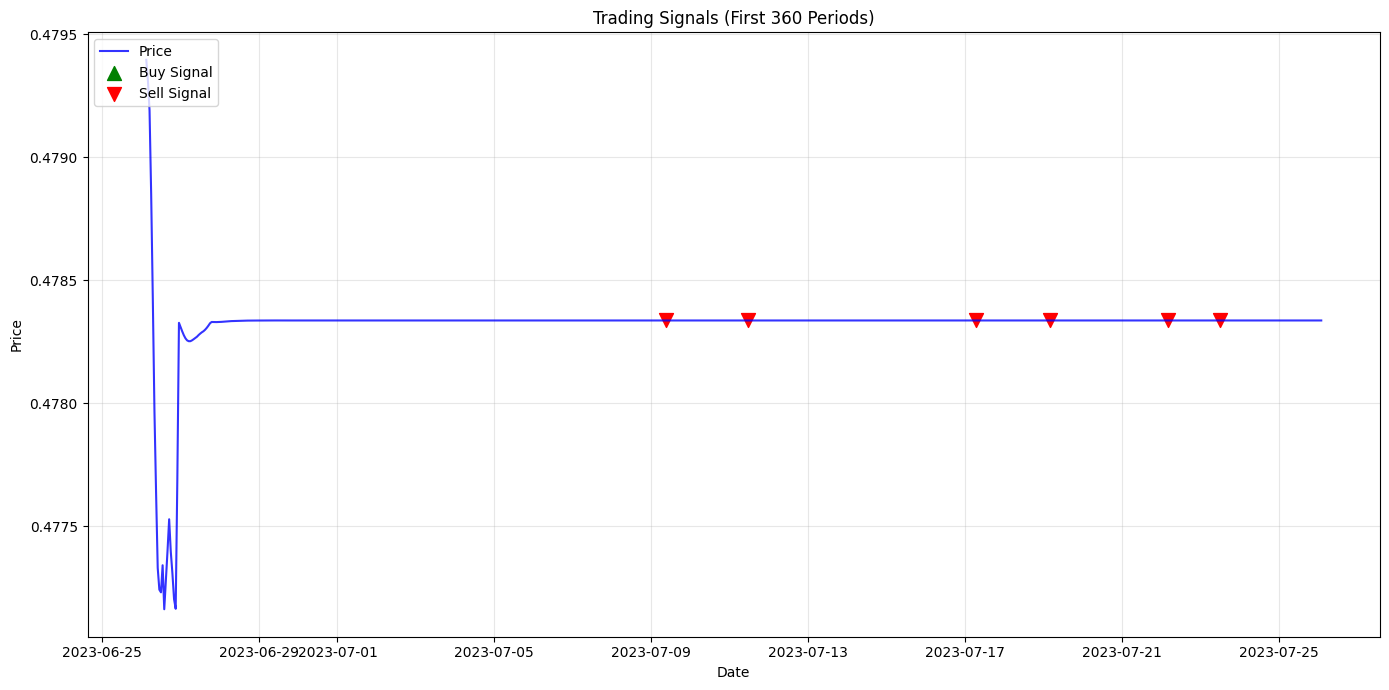

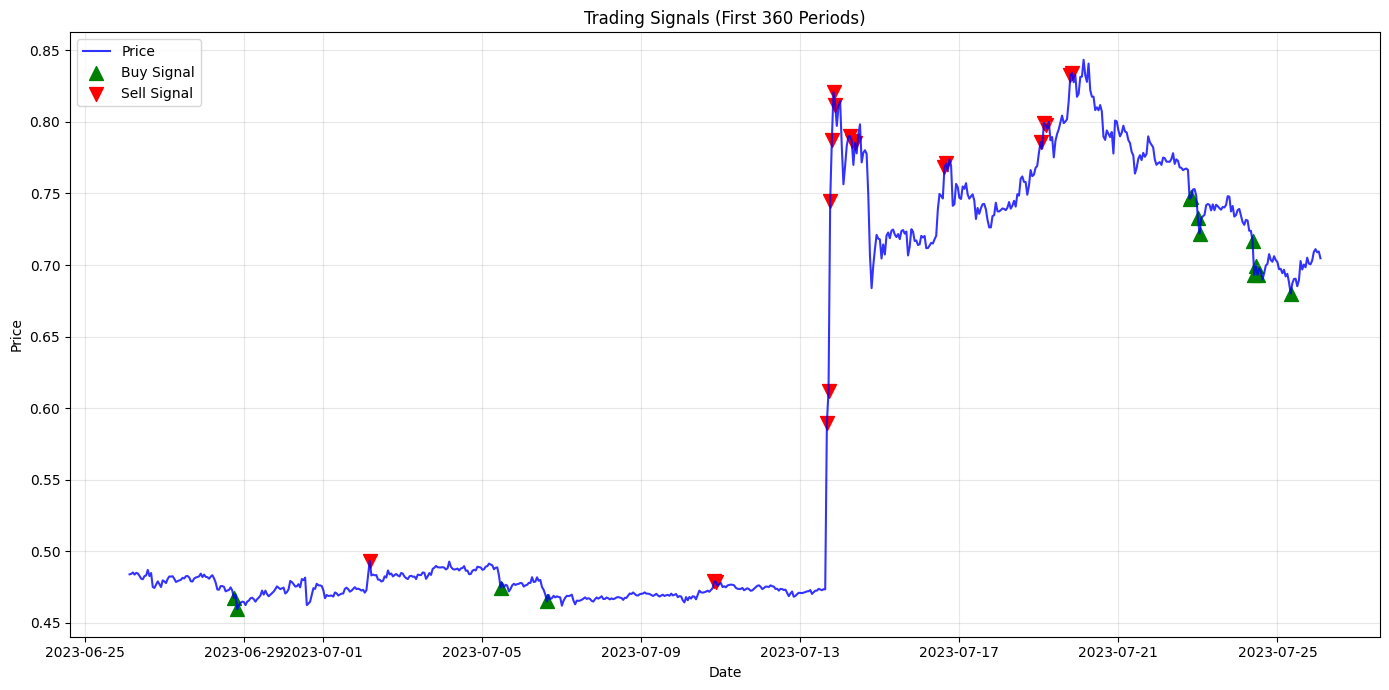

In [ ]:
for data in [prediction_data, truevalue_data]:
    plt.figure(figsize=(14, 7))

    # Plot price line (first 720 hours)
    plot_data = data.iloc[:720]

    plt.plot(plot_data.index, plot_data['close'], 
            label='Price', color='blue', alpha=0.8)

    # Buy signals
    plt.scatter(
        plot_data[plot_data['final_signal'] == 1].index,
        plot_data[plot_data['final_signal'] == 1]['close'],
        color='green',
        marker='^',
        s=100,
        label='Buy Signal'
    )

    # Sell signals
    plt.scatter(
        plot_data[plot_data['final_signal'] == -1].index,
        plot_data[plot_data['final_signal'] == -1]['close'],
        color='red',
        marker='v',
        s=100,
        label='Sell Signal'
    )

    plt.title('Trading Signals (First 720 Periods)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout() 
    plt.show()

In [29]:
for data in [prediction_data, truevalue_data]:
    # Calculate returns and account for transaction costs
    returns = []
    trade_count = 0
    fee_rate = 0.0006  # 0.06%

    position_storage = 0
    entry_prices = []  # Store entry prices for each position
    entry_times = []   # Store entry timestamps
    hourly_returns = np.zeros(len(data))  # Array to store returns for each hour
    cumulative_returns = np.zeros(len(data))  # Array to store cumulative returns

    for i in range(len(data)):
        current_price = data['close'].iloc[i]
        signal = data['final_signal'].iloc[i]
        
        # Buy signal
        if signal == 1:
            position_storage += 1
            trade_count += 1
            entry_price = current_price * (1 + fee_rate)  # Add fee to entry price
            entry_prices.append(entry_price)
            entry_times.append(i)
        
        # Sell signal and we have positions
        elif signal == -1 and position_storage > 0:
            exit_price = current_price * (1 - fee_rate)  # Subtract fee from exit price
            
            # Process each position we're closing
            for entry_price, entry_time in zip(entry_prices, entry_times):
                # Calculate total log return for the position
                total_log_return = np.log(exit_price / entry_price)
                
                # Calculate holding period
                holding_period = i - entry_time
                if holding_period > 0:
                    # Distribute the log return evenly across the holding period
                    per_hour_return = total_log_return / holding_period
                    hourly_returns[entry_time+1:i+1] += per_hour_return
            
            # Reset position tracking
            position_storage = 0
            entry_prices = []
            entry_times = []

    # Calculate cumulative returns
    cumulative_returns = np.exp(np.cumsum(hourly_returns)) - 1

    # Calculate maximum drawdown
    peaks = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - peaks) / (1 + peaks)
    max_drawdown = np.min(drawdowns)

    # Calculate metrics
    trade_frequency = trade_count / len(data)

    # Calculate Sharpe Ratio (using 365 * 24 hours per year)
    annual_factor = 365 * 24  # Hours in a year
    risk_free_rate = 0.02  # Assuming 2% annual risk-free rate

    # Use only non-zero returns for Sharpe calculation
    active_returns = hourly_returns[hourly_returns != 0]
    mean_hourly_return = np.mean(active_returns) if len(active_returns) > 0 else 0
    std_hourly_return = np.std(active_returns) if len(active_returns) > 0 else 0
    sharpe = np.sqrt(annual_factor) * (mean_hourly_return - risk_free_rate/annual_factor) / std_hourly_return if std_hourly_return > 0 else 0

    print(f"Number of trades: {trade_count}")
    print(f"Trading frequency (trades per hour): {trade_frequency:.4f}")
    print(f"Sharpe ratio: {sharpe:.4f}")
    print(f"Maximum drawdown: {max_drawdown:.4%}")

Number of trades: 0
Trading frequency (trades per hour): 0.0000
Sharpe ratio: 0.0000
Maximum drawdown: 0.0000%
Number of trades: 315
Trading frequency (trades per hour): 0.0200
Sharpe ratio: 27.8350
Maximum drawdown: -83.6286%
